In [1]:
import pandas as pd
import numpy as np
import time
import functools

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree

from typing import Any

from matplotlib import pyplot as plt

In [2]:
data = load_diabetes(as_frame=True)
X, y = data['data'], data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Модель дерева принятия решенией (регрессии), реализованная на Python с использованием библиотек Pandas и NumPy.

In [3]:
class Node:
    """Вспомогательный класс для реализации структуры дерева"""
    def __init__(self, 
                 column: str | None = None, 
                 value: float | None= None, 
                 left: Any = None, 
                 right: Any = None) -> None:
        self.column = column
        self.value = value
        self.left = left
        self.right = right

class MyTreeReg:
    """
    Дерево принятия решений, регрессия

    Параметры:
    max_depth : int
        Максимальная глубина дерева, by default 5.
    min_samples_split : int
        Кол-во объектов в листе, чтобы его можно было разбить и превратить в узел by default 2.    
    max_leafs : int
        Максимальное количество листьев у дерева by default 20.
    bins: int, optional
        Количество бинов, разбивающее фичи при обучении, by default None.
    ----------
    Методы:
    fit : построение регрессора дерева принятия решений из обучающего набора.
    predict: получение прогнозируемых значений регрессии для датасета Х.
    tree_traversal: отрисовка обученного дерева
    feature_importances: получение массива важности фичей
    """
    
    @staticmethod
    def timer(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            start = time.perf_counter()
            val = func(*args, **kwargs)
            end = time.perf_counter()
            work_time = end - start
            print(f'Время выполнения {func.__name__}: {round(work_time, 4)} сек.')
            return val
        return wrapper
    
    #Функция, вычисляющая MSE
    @staticmethod
    def __get_MSE(y: pd.Series) -> float:
        
        mse, n, y_mean = 0.0, y.shape[0], y.mean()
        for obj in y:
            mse += (obj - y_mean) ** 2
        return mse / y.shape[0] if y.shape[0] != 0 else 0

    def __init__(self, 
                 max_depth: int = 5, 
                 min_samples_split: int = 2, 
                 max_leafs: int = 20, 
                 bins: int | None = None) -> None:        
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_leafs = max_leafs
        self.bins = bins
        if self.max_leafs <= 1:
            self.max_leafs = 2
            self.max_depth = 1
        # добавление словаря для подсчета feature importance
        self.fi = {}
        # все строки в наборе данных, необходимые для определения feature importance
        self.N = 0
        
        self.split_values = {}
        self.leafs_cnt = 1
        self.leafs_sum = 0
        self.tree_structure = Node()

    def __str__(self) -> str:
        atr = self.__dict__
        res = ''.join([i + '=' + str(atr[i]) + ',' + ' ' for i in atr])[:-2]
        return 'MyTreeReg class: ' + res
    
    #Вспомогательная функция. Ищет наилучшее разбиение датасета   
    def __get_best_split(self, X: pd.DataFrame, y: pd.Series) -> (str, float, float):       
  
        if X.shape[0] != y.shape[0]: 
            raise ValueError("X and y must be the same size")
        
        col_name, split_value, ig_max, ig_start = '', 0.0, 0.0, MyTreeReg().__get_MSE(y)
        N = y.shape[0]
        form_spliters = len(self.split_values) == 0
        
        #итеративный проход по фичам
        for column in X.columns:
            if form_spliters:
                # формирование уникальных разделителей
                vals = np.sort(X[column].unique())
                if self.bins is not None and len(vals) - 1 >= self.bins:
                    spliters = np.histogram(X[column], bins=self.bins)[1]#[1:-1]
                else:
                    spliters = np.convolve(vals, [0.5, 0.5], 'valid')
                self.split_values[column] = spliters
                
            # поиск наилучшего прироста энтропии в фиче    
            for spliter in self.split_values[column]:
                left, right = X[X[column] <= spliter].index, X[X[column] > spliter].index
                X_left, y_left = X.loc[left], y.loc[left]
                X_right, y_right = X.loc[right], y.loc[right]
                ig = ig_start - ((y_left.shape[0] / N) * MyTreeReg().__get_MSE(y_left) + \
                                (y_right.shape[0] / N) * MyTreeReg().__get_MSE(y_right))
                if ig > ig_max:
                    ig_max = ig
                    col_name = column
                    split_value = spliter
                    
        return col_name, split_value, ig_max
    
    #Функция, определяющая можно ли узел превратить в лист
    #Возвращает True, если узел должен быть превращен лист, иначе False
    def __is_leaf(self, y: pd.Series, depth: int) -> bool:
        
        
        if y.shape[0] <= 1: return True
        if depth == self.max_depth: return True
        if y.shape[0] < self.min_samples_split: return True
        if self.leafs_cnt > 1 and self.leafs_cnt >= self.max_leafs: return True
        return False
    
    #Функция, формирующая дерево
    def __form_tree(self, X: pd.DataFrame, y: pd.Series, node: Node, depth: int) -> None:
        if not self.__is_leaf(y, depth):
            col_name, split_value, ig = self.__get_best_split(X, y)
            left, right = X[X[col_name] <= split_value].index, X[X[col_name] > split_value].index
            X_left, y_left = X.loc[left], y.loc[left]
            X_right, y_right = X.loc[right], y.loc[right]
            self.fi[col_name] += X.shape[0] / self.N * ig
            node.column, node.value = col_name, split_value
            node.left = Node()
            node.right = Node()
            self.leafs_cnt += 1
            self.__form_tree(X_left, y_left, node.left, depth + 1), self.__form_tree(X_right, y_right, node.right, depth + 1)
        else:
            node.value = y.mean()
            self.leafs_sum += node.value
            return node   

    @timer
    def fit(self, X: pd.DataFrame, y: pd.Series) -> None:
        """Обучение дерева принятия решений

        Parameters
        ----------
        X : pd.DataFrame
            Все фичи
        y : pd.Series
            Целевая переменная
        """
        
        if self.tree_structure.column: self.tree_structure == Node()
        for feature in X.columns: self.fi[feature] = 0
        self.N = X.shape[0]
        self.__form_tree(X, y, self.tree_structure, 0)        
        
    #Предсказание для одной строки
    def __predict_row(self, row: pd.Series) -> float:
        tree = self.tree_structure
        while tree.column:
            if row[tree.column] <= tree.value:
                tree = tree.left
            else:
                tree = tree.right
        return tree.value    
    
    @timer
    def predict(self, X: pd.DataFrame) -> np.array:
        """Выдача предсказаний моделью

        Parameters
        ----------
        X : pd.DataFrame
            Матрица фичей
        """
        if self.tree_structure.column is None: raise UnfittedModel()
        res = []
        for row in X.index:
            res.append(self.__predict_row(X.loc[row]))
        return np.array(res)
    
    def tree_traversal(self, tree: Node = None, depth: int = 0, side: str = 'left') -> None:
        """Отрисовка полученного дерева принятия решений"""
        
        if tree is None:
            tree = self.tree_structure
        if tree.column is not None:
            print(f"{' ' * depth}{tree.column} > {tree.value}")
            if tree.left is not None:
                self.tree_traversal(tree.left, depth + 1, 'left')
            if tree.right is not None:
                self.tree_traversal(tree.right, depth + 1, 'right')
        else:
            print(f"{' ' * depth}{side} leaf = {tree.value}")            
            
    def feature_importances(self) -> np.array:
        arr = np.array([i for i in self.fi.values()])
        t_min = 0
        t_max = arr.max() / arr.sum()
        norm_arr = []
        diff = t_max - t_min
        diff_arr = max(arr) - min(arr)    
        for i in arr:
            temp = (((i - min(arr))*diff)/diff_arr) + t_min
            norm_arr.append(temp)
        return np.array(norm_arr)

In [4]:
arguments = {"max_depth": 4, "min_samples_split": 50, "max_leafs": 17, 'bins': 5}
my_tree = MyTreeReg(**arguments)
my_tree.fit(X_train, y_train)
y_pred = my_tree.predict(X_test)
print(f'Значение MSE: {mean_squared_error(y_test, y_pred)}')

Время выполнения fit: 0.2543 сек.
Время выполнения predict: 0.0025 сек.
Значение MSE: 3081.0919378894696


In [5]:
#отрисовка дерева
my_tree.tree_traversal()

bmi > 0.010823476631509552
 s5 > -0.009180401757927212
  s3 > 0.01108739384846183
   left leaf = 114.77083333333333
   sex > 0.003019241116414738
    left leaf = 98.92857142857143
    right leaf = 71.1
  s3 > -0.04560982833447707
   left leaf = 184.0625
   s6 > 0.026260208137441426
    left leaf = 130.84444444444443
    right leaf = 162.8
 bp > 0.03426664902709402
  bmi > 0.11084443708764775
   s6 > 0.026260208137441426
    left leaf = 161.45
    right leaf = 215.65
   right leaf = 306.6666666666667
  right leaf = 240.97619047619048


Массив feature importance: 
 [0.         0.01243882 0.65434648 0.09170745 0.         0.
 0.04840885 0.         0.12990097 0.06319742]


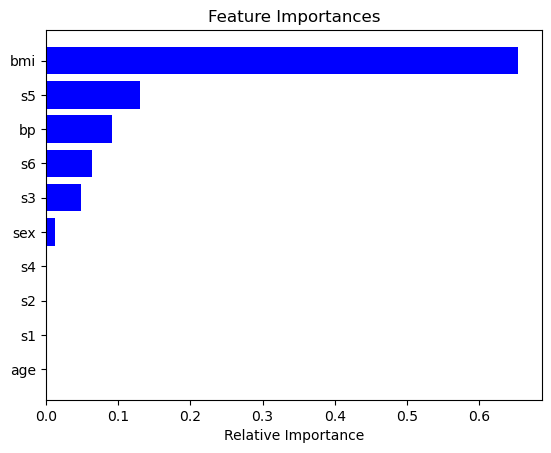

In [6]:
#feature importance
print('Массив feature importance:', '\n', my_tree.feature_importances())

features = X.columns
importances = my_tree.feature_importances()
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Модель дерева принятия решений, реализованная с использованием sklearn

In [7]:
tree_sklearn = DecisionTreeRegressor(max_leaf_nodes=17, min_samples_split=50, max_depth=4)
y_pred_sklearn = tree_sklearn.fit(X_train, y_train).predict(X_test)
print(f'Значение MSE: {mean_squared_error(y_test, y_pred_sklearn)}')

Значение MSE: 4101.447479060349


In [8]:
text_representation = tree.export_text(tree_sklearn)
print(text_representation)

|--- feature_2 <= 0.01
|   |--- feature_8 <= -0.00
|   |   |--- feature_5 <= 0.09
|   |   |   |--- feature_8 <= -0.04
|   |   |   |   |--- value: [79.15]
|   |   |   |--- feature_8 >  -0.04
|   |   |   |   |--- value: [107.58]
|   |   |--- feature_5 >  0.09
|   |   |   |--- value: [241.50]
|   |--- feature_8 >  -0.00
|   |   |--- feature_7 <= 0.10
|   |   |   |--- feature_0 <= 0.10
|   |   |   |   |--- value: [146.30]
|   |   |   |--- feature_0 >  0.10
|   |   |   |   |--- value: [277.00]
|   |   |--- feature_7 >  0.10
|   |   |   |--- value: [256.33]
|--- feature_2 >  0.01
|   |--- feature_2 <= 0.07
|   |   |--- feature_3 <= 0.02
|   |   |   |--- value: [160.72]
|   |   |--- feature_3 >  0.02
|   |   |   |--- value: [223.00]
|   |--- feature_2 >  0.07
|   |   |--- value: [273.73]



Массив feature importance: 
 [0.01745434 0.         0.66809692 0.08720323 0.         0.04235234
 0.         0.03482588 0.15006728 0.        ]


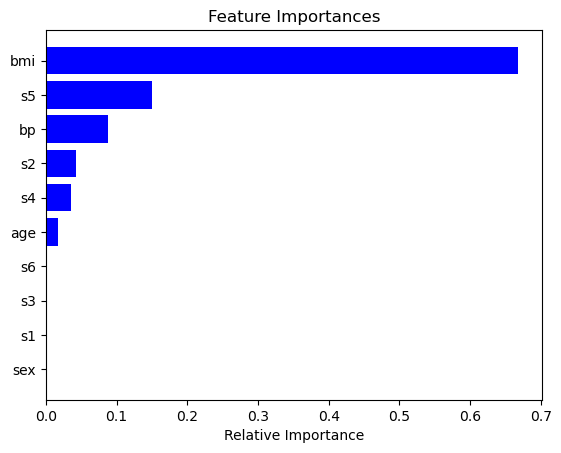

In [9]:
print('Массив feature importance:', '\n', tree_sklearn.feature_importances_)

features = X.columns
importances = tree_sklearn.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()